In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def numerical_grad(f, eps=1e-6):
    """
    Creates a function that computes the numerical gradient of f.
    """
    def grad_f(x):
        g = np.zeros_like(x)
        for i in range(len(x)):
            x_plus_h = x.copy()
            x_plus_h[i] += eps
            x_minus_h = x.copy()
            x_minus_h[i] -= eps
            g[i] = (f(x_plus_h) - f(x_minus_h)) / (2 * eps)
        return g
    return grad_f

def numerical_hess(f, eps=1e-5):
    """
    Creates a function that computes the numerical Hessian of f.
    """
    def hess_f(x):
        n = len(x)
        H = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                x_ii = x.copy(); x_ii[i] += eps; x_ii[j] += eps
                x_i  = x.copy(); x_i[i]  += eps; x_i[j] -= eps
                x_j  = x.copy(); x_j[i]  -= eps; x_j[j] += eps
                x_   = x.copy(); x_[i]   -= eps; x_[j] -= eps
                H[i, j] = (f(x_ii) - f(x_i) - f(x_j) + f(x_)) / (4 * eps**2)
        return H
    return hess_f


def armijo_backtracking(f, grad, x, d, alpha0=1.0, c=1e-4, rho=0.5, max_trials=30):
    g = grad(x)
    if np.dot(g, d) >= 0:
        return 0.0
    fx = f(x)
    alpha = alpha0
    for _ in range(max_trials):
        xn = x + alpha * d
        if f(xn) <= fx + c * alpha * np.dot(g, d):
            return alpha
        alpha *= rho
    return alpha

def run_gradient_descent(f, grad, x0, max_iter=200, tol=1e-8):
    xs = [x0.copy()]
    x = x0.copy()
    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol: break
        d = -g
        alpha = armijo_backtracking(f, grad, x, d)
        if alpha == 0.0: break
        x += alpha * d
        xs.append(x.copy())
    return np.array(xs)

def make_pd(H):
    try:
        w = np.linalg.eigvalsh(H)
        lam_min = np.min(w)
        if lam_min > 1e-6: return H
        shift = (1e-6 - lam_min)
        return H + shift * np.eye(H.shape[0])
    except np.linalg.LinAlgError:
        return np.eye(H.shape[0])

def run_modified_newton(f, grad, hess, x0, max_iter=100, tol=1e-8):
    xs = [x0.copy()]
    x = x0.copy()
    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol: break
        H = make_pd(hess(x))
        try:
            d = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            d = -g
        alpha = armijo_backtracking(f, grad, x, d)
        if alpha == 0.0: break
        x += alpha * d
        xs.append(x.copy())
    return np.array(xs)

def run_newton(f, grad, hess, x0, max_iter=200, tol=1e-8):
    xs = [x0.copy()]
    x = x0.copy()
    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol: break
        H = hess(x)
        try:
            d = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            break
        alpha = armijo_backtracking(f, grad, x, d)
        if alpha == 0.0: break
        x += alpha * d
        xs.append(x.copy())
    return np.array(xs)

def run_bfgs_inverse(f, grad, x0, max_iter=200, tol=1e-8):
    xs = [x0.copy()]
    x = x0.copy()
    B = np.eye(len(x0))
    g = grad(x)
    for _ in range(max_iter):
        if np.linalg.norm(g) < tol: break
        d = -B.dot(g)
        alpha = armijo_backtracking(f, grad, x, d)
        if alpha == 0.0: break
        x_new = x + alpha * d
        g_new = grad(x_new)
        s = x_new - x
        y = g_new - g
        ys = np.dot(y, s)
        if ys > 1e-12:
            rho = 1.0 / ys
            I = np.eye(len(x0))
            V = I - rho * np.outer(s, y)
            B = V @ B @ V.T + rho * np.outer(s, s)
        x, g = x_new, g_new
        xs.append(x.copy())
    return np.array(xs)


def draw_contours(ax, f, xlim, ylim, levels=40, ngrid=300):
    x_pts = np.linspace(xlim[0], xlim[1], ngrid)
    y_pts = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(x_pts, y_pts)
    Z = np.zeros_like(X)
    for i in range(ngrid):
        for j in range(ngrid):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

    Z = np.nan_to_num(Z, nan=np.nan, posinf=1e5, neginf=-1e5)
    min_z, max_z = np.nanmin(Z), np.nanmax(Z)
    
    if min_z * max_z < 0:
        level_set = np.linspace(min_z, max_z, levels)
    else:
        log_min = np.log10(abs(min_z) + 1e-9)
        log_max = np.log10(abs(max_z) + 1e-9)
        level_set = np.logspace(log_min, log_max, levels)
        if min_z < 0: level_set = -level_set[::-1]
    
    ax.contourf(X, Y, Z, levels=level_set, alpha=0.8, cmap='viridis', extend='both')
    ax.contour(X, Y, Z, levels=level_set, linewidths=0.5, colors='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')


def plot_trajectories(title, f, grad, hess, x0, xlim, ylim, max_iters, filename, save=True):
    traj_gd = run_gradient_descent(f, grad, x0, max_iter=max_iters.get('gd', 200))
    print("GD: final point", traj_gd[-1])
    traj_bfgs = run_bfgs_inverse(f, grad, x0, max_iter=max_iters.get('bfgs', 200))
    print("BFGS: final point", traj_bfgs[-1])
    traj_mod_newton = run_modified_newton(f, grad, hess, x0, max_iter=max_iters.get('mod_newton', 100))
    print("Modified Newton: final point", traj_mod_newton[-1])
    traj_newton = run_newton(f, grad, hess, x0, max_iter=max_iters.get('newton', 200))
    print("Newton: final point", traj_newton[-1])

    fig, ax = plt.subplots(figsize=(8, 7))
    draw_contours(ax, f, xlim, ylim)

    paths = {
        f'Gradient Descent ({len(traj_gd)-1} steps)': (traj_gd, 'o-'),
        f'BFGS ({len(traj_bfgs)-1} steps)': (traj_bfgs, 's-'),
        f'Modified Newton ({len(traj_mod_newton)-1} steps)': (traj_mod_newton, '^-'),
        f'Newton ({len(traj_newton)-1} steps)': (traj_newton, '*-')
    }
    
    for label, (traj, style) in paths.items():
        if len(traj) > 1:
            ax.plot(traj[:, 0], traj[:, 1], style, label=label, markersize=5)
            ax.plot(traj[-1, 0], traj[-1, 1], 'x', markersize=12, markeredgewidth=2)

    ax.plot(x0[0], x0[1], '*', color='cyan', markersize=15, markeredgewidth=1.5, markeredgecolor='black', label='Start')
    ax.set_title(title, fontsize=14)
    ax.legend(loc='best')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    fig.tight_layout()
    if save:
        fig.savefig(filename, bbox_inches='tight', transparent=True)
    plt.show()



GD: final point [3.00042229 0.50010752]
BFGS: final point [3.00000001 0.5       ]
Modified Newton: final point [3.  0.5]
Newton: final point [1.01879644e-10 1.00000000e+00]


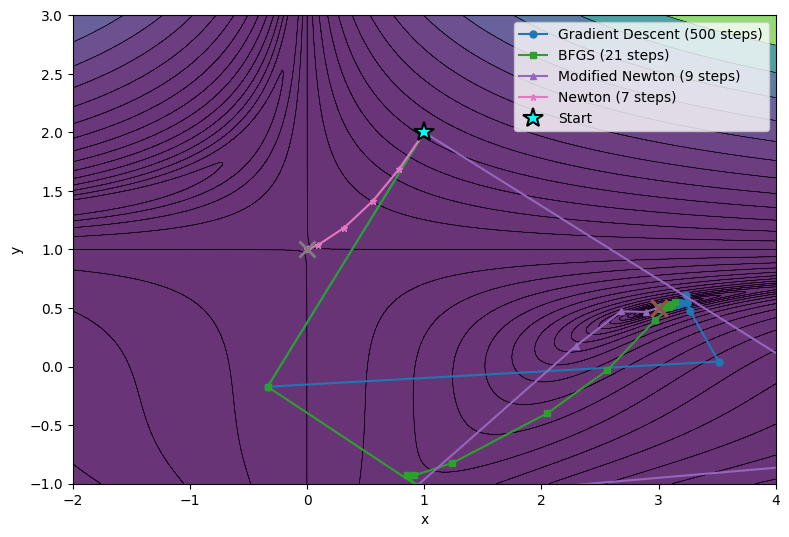

In [9]:
def f_beale(v):
    x, y = v
    # Clip inputs to prevent overflow during optimization steps
    x, y = np.clip(x, -100, 100), np.clip(y, -100, 100)
    t1 = 1.5 - x + x*y
    t2 = 2.25 - x + x*y**2
    t3 = 2.625 - x + x*y**3
    return t1**2 + t2**2 + t3**2

g_beale_num = numerical_grad(f_beale)
H_beale_num = numerical_hess(f_beale)

plot_trajectories(
    # title="Beale's Function (Numerical Derivatives)",
    title="",
    f=f_beale, grad=g_beale_num, hess=H_beale_num,
    x0=np.array([1.0, 2.0]), xlim=(-2, 4), ylim=(-1, 3),
    max_iters={'gd': 500, 'bfgs': 100, 'mod_newton': 20, 'newton': 20},
    filename="../../../figs/optimization/paths_beale.pdf",
    save=False
)

GD: final point [6.67077142e-10 0.00000000e+00]
BFGS: final point [-5.03442328e-10 -8.20414043e-10]
Modified Newton: final point [1.13735152e-13 0.00000000e+00]
Newton: final point [1.13735152e-13 0.00000000e+00]


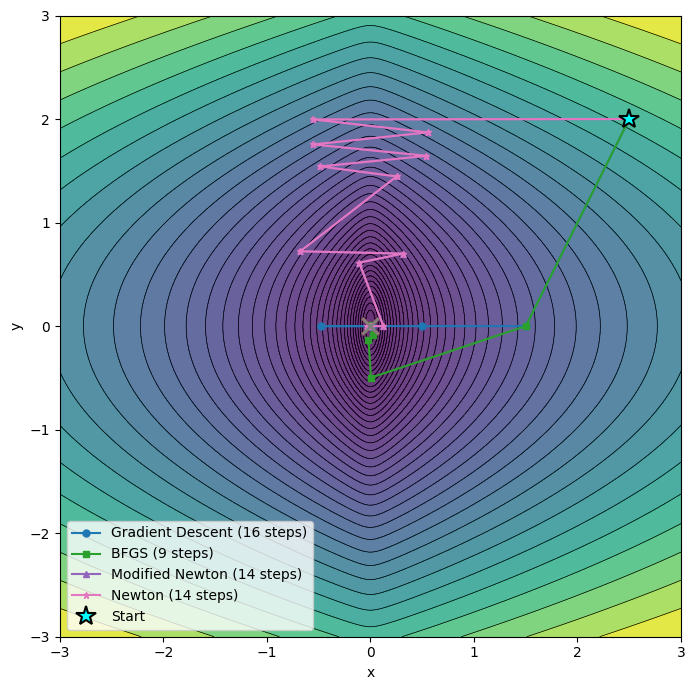

In [14]:

epsilon = 0.01
def f_crease(v):
    x, y = v
    return np.sqrt(x**2 + epsilon) + 0.5*y**2
def g_crease(v):
    x, y = v
    return np.array([x / np.sqrt(x**2 + epsilon), y])
def H_crease(v):
    x, y = v
    return np.array([ [epsilon / (x**2 + epsilon)**1.5, 0.0], [0.0, 1.0] ])

plot_trajectories(
    # title="Sharp Crease: Failure of the Quadratic Model",
    title="",
    f=f_crease, grad=g_crease, hess=H_crease,
    x0=np.array([2.5, 2.0]), xlim=(-3, 3), ylim=(-3, 3),
    max_iters={'gd': 50, 'bfgs': 50, 'mod_newton': 50, 'newton': 50},
    filename="../../../figs/optimization/paths_crease.pdf",
    save=True
)

GD: final point [ 43432.74654244 -16160.97568946]
BFGS: final point [    2730.79114264 -1090690.27566928]
Modified Newton: final point [-1.80577546e+11 -1.66703833e+09]
Newton: final point [-0.00048828  0.00073242]


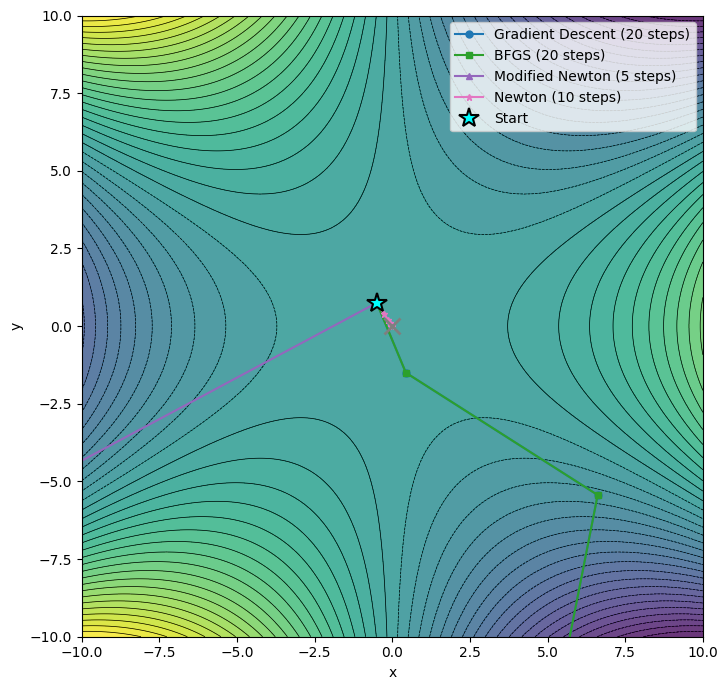

In [11]:

def f_saddle(v):
    x, y = v
    # Clip inputs to prevent overflow
    x, y = np.clip(x, -1e3, 1e3), np.clip(y, -1e3, 1e3)
    return x**3 - 3*x*y**2
def g_saddle(v):
    x, y = v
    return np.array([3*x**2 - 3*y**2, -6*x*y])
def H_saddle(v):
    x, y = v
    return np.array([[6*x, -6*y], [-6*y, -6*x]])

plot_trajectories(
    # title="Monkey Saddle: Escaping a Degenerate Critical Point",
    title="",
    f=f_saddle, grad=g_saddle, hess=H_saddle,
    x0=np.array([-0.5, 0.75]), xlim=(-10, 10), ylim=(-10, 10),
    max_iters={'gd': 20, 'bfgs': 20, 'mod_newton': 10, 'newton': 10},
    filename="../../../figs/optimization/paths_saddle.pdf",
    save=False
)

GD: final point [0.         3.05841934]
BFGS: final point [ 1.82558174e-10 -1.86653353e-10]
Modified Newton: final point [     0.       -37717.961399]
Newton: final point [0.         3.14161665]


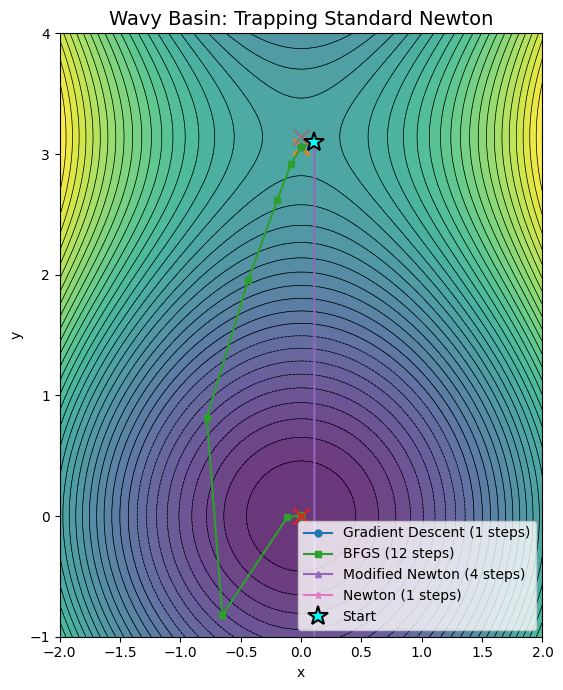

In [15]:

def f_wavy(v):
    x, y = v
    return 0.5 * x**2 - np.cos(y)

def g_wavy(v):
    x, y = v
    return np.array([x, np.sin(y)])

def H_wavy(v):
    x, y = v
    return np.array([[1.0, 0.0], [0.0, np.cos(y)]])

plot_trajectories(
    title="Wavy Basin: Trapping Standard Newton",
    f=f_wavy,
    grad=g_wavy,
    hess=H_wavy,
    x0=np.array([0.11, 3.1]),  # Start near the saddle point at (0, pi)
    xlim=(-2, 2),
    ylim=(-1, 4),
    max_iters={'gd': 1, 'bfgs': 50, 'mod_newton': 15, 'newton': 15},
    filename="../../../figs/optimization/paths_wavy_basin_trap.pdf",
    save=False
)

GD: final point [ 1.00000000e+00 -1.68781655e-12]
BFGS: final point [ 1.00000000e+00 -7.09057594e-11]
Modified Newton: final point [ 1.00000000e+00 -4.49396272e-12]
Newton: final point [0.5 0.3]


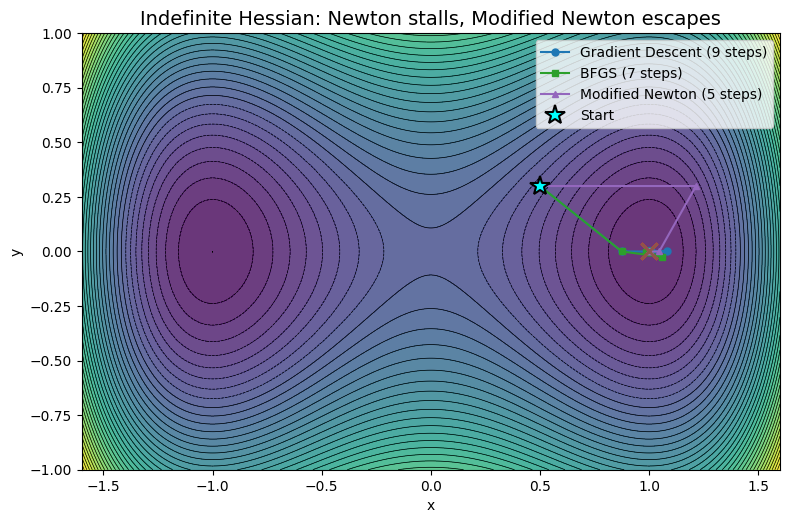

In [13]:

def f_double_well(v):
    """
    Double-well in x, quadratic in y.
    Newton fails near x=0 because H is indefinite (H_xx = 3x^2 - 1 < 0 for |x| < 1/sqrt(3)).
    """
    x, y = v
    # (No clipping needed here; the function is benign)
    return 0.25 * x**4 - 0.5 * x**2 + 0.5 * y**2

# Use your numerical derivatives to emphasize the "all numerically" requirement
g_double_well_num = numerical_grad(f_double_well, eps=1e-6)
H_double_well_num = numerical_hess(f_double_well, eps=1e-5)

# Start inside the indefinite strip so that plain Newton's direction is NOT a descent direction
# (g^T d >= 0), triggering alpha=0.0 from Armijo and an immediate stall.
plot_trajectories(
    title="Indefinite Hessian: Newton stalls, Modified Newton escapes",
    f=f_double_well, grad=g_double_well_num, hess=H_double_well_num,
    x0=np.array([0.50, 0.30]),
    xlim=(-1.6, 1.6), ylim=(-1.0, 1.0),
    max_iters={'gd': 200, 'bfgs': 200, 'mod_newton': 100, 'newton': 50},
    filename="../../../figs/optimization/paths_double_well.pdf",
    save=False
)